# Inversions with okapy and SciPy: the sandbox

Gareth Funning, University of California, Riverside

A simple inversion making use of the Powell algorithm built into the scipy.optimize.minimize function, the Okada model in okapy and our downsampled data in 'okinv' format to try to obtain a best-fitting model of an earthquake.

Why the "sandbox" name? Well, this is where I am playing around with things! You might think of it as a development version.

## Set it up! 

Let's start with some dependencies:

In [25]:
from okapy import rect_shear_fault, los_penalty_fault
from math import sin, cos, tan, radians, floor
from matplotlib import cm, colors
from scipy.optimize import minimize, Bounds
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import time

## Defining the data, model parameters and elastic constants

Load in the downsampled interferogram data. We make use of lists here to import as many datasets as you want.

In [4]:
# let's try to make a list!
data = list()
datanames = list()

# load in a data file (need to copy this block for each data file)
# add the full path to the data file here:
indata = np.loadtxt('./pishan_asc_cropped.okinv', 
                    usecols=(0,1,2,3,4,5))
indata[:,0]*=1000  # convert x coord from km to m
indata[:,1]*=1000  # convert y coord from km to m
data.append(indata)
dataname = 'Pishan ascending'
datanames.append(dataname)

# load in a data file (need to copy this block for each data file)
# add the full path to the data file here:
indata = np.loadtxt('./pishan_dsc_cropped.okinv', 
                    usecols=(0,1,2,3,4,5))
indata[:,0]*=1000  # convert x coord from km to m
indata[:,1]*=1000  # convert y coord from km to m
data.append(indata)
dataname = 'Pishan descending'
datanames.append(dataname)

Let's specify some parameters for our models: starting guesses and uncertainties

In [64]:
# for each quantity, starting guess is the first value, sigma the second
strike = [105, 10]        # in degrees
dip = [24, 10]           # in degrees
rake = [70, 20]           # in degrees
slip = [.4, 0.75]          # in m
xs = [775000, 5000]        # x coord of center of updip fault projection, in m 
ys = [4170000, 10000]       # y coord of same, in m
as_length = [15000, 5000]     # along-strike fault length, in m
top_depth = [2500, 2000]      # depth of top edge of fault, in m
bottom_depth = [7000, 5000]  # depth to bottom edge of fault

fpstart = np.array([strike[0], dip[0], rake[0], slip[0], xs[0], ys[0], as_length[0],
                    top_depth[0], bottom_depth[0]])
fpsigma = np.array([strike[1], dip[1], rake[1], slip[1], xs[1], ys[1], as_length[1], 
                    top_depth[1], bottom_depth[1]])

# let's calculate some 2-sigma bounds on these starting values:
fplowb = fpstart-2*fpsigma
fphighb = fpstart+2*fpsigma

Finally, let's define some elastic parameters, using some standard values:

In [65]:
eparams = np.array([30e9, 30e9])  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

## Parallelized looping to find the global minimum

This makes use of the `joblib` routines for embarrassingly parallel (i.e. completely independent) problems. I think I've got it working properly!

In [66]:
nrestarts=100   # how many restarts do you want?
njobs=8         # how many parallel processes?

# set a timer
t1=time.time()

# we need a function to use in the parallel loop
def powell_optimize(i,fpstart,fpsigma,fplowb,fphighb,eparams,data):

    # find a random starting model (assume flat pdf between lower and upper bounds)
    fparams_restart = fpstart + np.multiply(((np.random.rand(9)*4)-2),fpsigma)

    # sanity check of depths (make sure bottom depth is greater than top depth)
    if fparams_restart[7] > fparams_restart[8]:
        bottom = fparams_restart[7]
        fparams_restart[7] = fparams_restart[8] 
        fparams_restart[8] = bottom

    # also check that the depths are within bounds after you did that
    if fparams_restart[7] < fplowb[7]:
        fparams_restart[7]=fplowb[7]
    if fparams_restart[7] > fphighb[7]:
        fparams_restart[7]=fphighb[7]
    if fparams_restart[8] < fplowb[8]:
        fparams_restart[8]=fplowb[8] 
    if fparams_restart[8] > fphighb[8]:
        fparams_restart[8]=fphighb[8] 
        
    # set inversion bounds
    fpbounds = Bounds(fplowb,fphighb)
        
    # and run the Powell algorithm minimizer! 
    results = minimize(los_penalty_fault, fparams_restart, args=(eparams, data),  method='Powell', 
                   bounds=fpbounds)
    
    #print("restart {0:d}, penalty: {1:f}".format(i,results.fun))
    
    return results.fun, results.x
    

# and we can run the parallel loop now... easy when you know how
results = Parallel(n_jobs=njobs)(delayed(powell_optimize)(i,fpstart,fpsigma,fplowb,fphighb,eparams,data)
                                 for i in range(nrestarts))

# done? check the time
t2=time.time()


# with the inversion done, let's parse the results (which are a list of lists)
penalties=[item[0] for item in results]
fparams=[item[1] for item in results]

# what is the best penalty?
best_penalty=np.min(penalties)

# find the index for the best penalty
idx=[i for i in range(len(penalties)) if penalties[i]==best_penalty]

# and the best parameters are...
best_fparams=fparams[idx[0]]

print('{0:d} restarts completed in {1:f} seconds'.format(nrestarts,t2-t1))
print('best penalty: {0:f}'.format(best_penalty))
print(' ')
print("final fault parameters:")
print('  strike:',best_fparams[0],' dip:',best_fparams[1],' rake:',best_fparams[2],' slip:',best_fparams[3])
print('  xs:',best_fparams[4],' ys:',best_fparams[5])
print('  length:',best_fparams[6],' top:',best_fparams[7],' bottom:',best_fparams[8])


100 restarts completed in 165.531585 seconds
best penalty: 0.028569
 
final fault parameters:
  strike: 120.92615505181999  dip: 14.70261655640158  rake: 106.26914450938045  slip: 0.37212465514156556
  xs: 784694.1854622265  ys: 4182779.463061236
  length: 23677.037558845914  top: 6499.998242315354  bottom: 9941.276622157342


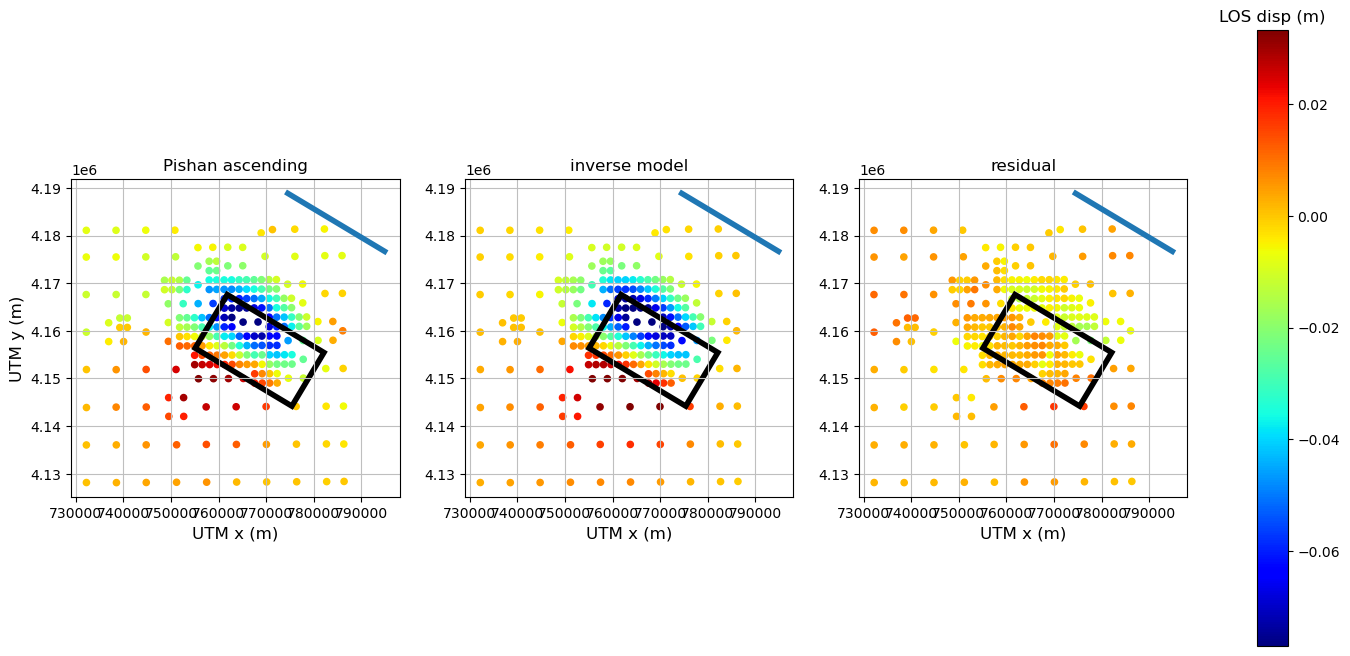

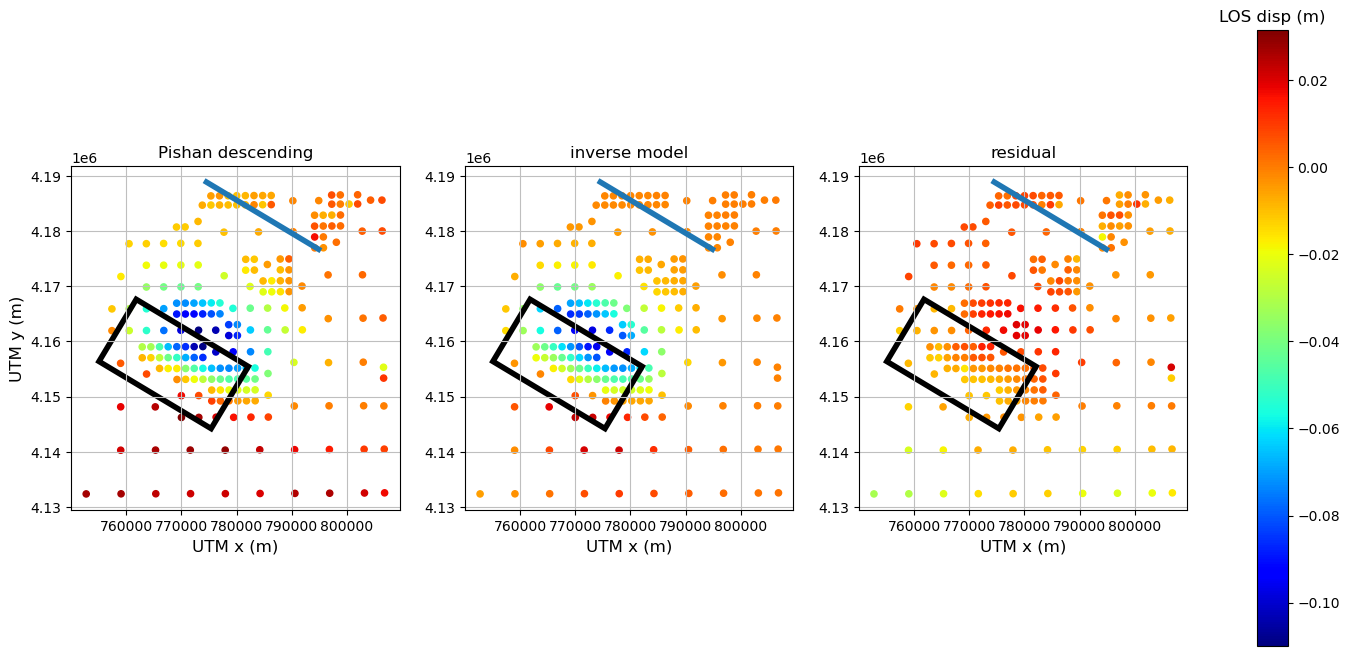

In [67]:
# Plot the 'best' model

# calculate the displacements
model_los_disps = rect_shear_fault(best_fparams, eparams, data)

# exteact fault location for plotting

#top of the fault
linex=[best_fparams[4]+(best_fparams[6]/2)*np.sin(np.radians(best_fparams[0])),
       best_fparams[4]-(best_fparams[6]/2)*np.sin(np.radians(best_fparams[0]))]
liney=[best_fparams[5]+(best_fparams[6]/2)*np.cos(np.radians(best_fparams[0])),
       best_fparams[5]-(best_fparams[6]/2)*np.cos(np.radians(best_fparams[0]))]

#top and bottom of the fault factors
r1=best_fparams[7]/np.tan(np.radians(best_fparams[1]))
r2=best_fparams[8]/np.tan(np.radians(best_fparams[1]))

#arrays for the fault shape
faultx=[linex[0]+r1*np.sin(np.radians(best_fparams[0]+90)), linex[0]+r2*np.sin(np.radians(best_fparams[0]+90)), 
        linex[1]+r2*np.sin(np.radians(best_fparams[0]+90)), linex[1]+r1*np.sin(np.radians(best_fparams[0]+90))]

faulty=[liney[0]+r1*np.cos(np.radians(best_fparams[0]+90)), liney[0]+r2*np.cos(np.radians(best_fparams[0]+90)), 
        liney[1]+r2*np.cos(np.radians(best_fparams[0]+90)), liney[1]+r1*np.cos(np.radians(best_fparams[0]+90))]

# parse the input data
ndset = len(data)

# loop through your datasets
for i in range(ndset):

    # grab yer data
    dataset=data[i]
    
    # calculate the mean residual
    zero_shift = np.mean(dataset[:,2]-model_los_disps[i])
    
    # calculate the residual without nuisances...
    shifted_data = dataset[:,2]-zero_shift
    residual_los_disps = model_los_disps[i]-shifted_data
    
    # color limits based on the shifted data
    cmin, cmax = shifted_data.min(), shifted_data.max()
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
    axlist = [ax1,ax2,ax3]   # handles for your subplots
    


    
    # FORWARD MODEL- scatter with colormap mapping to z value
    scat=ax1.scatter(dataset[:,0],dataset[:,1],s=20,c=shifted_data, 
                     marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
    # add fault shape to forawrd model
    ax1.plot(linex,liney,linewidth=4)
    ax1.fill(faultx,faulty,linewidth=4,fill=False)
    #plot forward model
    ax1.set_xlabel("UTM x (m)",fontsize=12)
    ax1.set_ylabel("UTM y (m)",fontsize=12)
    ax1.title.set_text(datanames[i])
    ax1.grid(True,linestyle='-',color='0.75')
    ax1.set_aspect('equal')

    # INVERSE MODEL-scatter with colormap mapping to z value
    scat=ax2.scatter(dataset[:,0],dataset[:,1],s=20,c=model_los_disps[i], 
                     marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
    #add fault shape to inverse model
    ax2.plot(linex,liney,linewidth=4)
    ax2.fill(faultx,faulty,linewidth=4,fill=False)
    #plot inverse modal 
    ax2.set_xlabel("UTM x (m)",fontsize=12)
    ax2.title.set_text('inverse model')
    ax2.grid(True,linestyle='-',color='0.75')
    ax2.set_aspect('equal')

    # RESIDAL MODEL-scatter with colormap mapping to z value
    scat=ax3.scatter(dataset[:,0],dataset[:,1],s=20,c=residual_los_disps, 
                     marker = 'o', cmap = cm.jet, vmin = cmin, vmax = cmax);
    #add on fault shape to the data graph
    ax3.plot(linex,liney,linewidth=4)
    ax3.fill(faultx,faulty,linewidth=4,fill=False)
    #plot it 
    ax3.set_xlabel("UTM x (m)",fontsize=12)
    ax3.title.set_text('residual')
    ax3.grid(True,linestyle='-',color='0.75')
    ax3.set_aspect('equal')

    clb=fig.colorbar(scat,ax=axlist)
    clb.ax.set_title('LOS disp (m)')
    plt.show();

## Changelog

Keeping track of changes!

```
    2020-07-13    gjf   genesis of okapy.py
    2020-08-03    gjf   original notebook posted
    2021-12-30    gjf   added multiple data file functionality
    2022-01-12    kmr   added better fault plotting
    2025-03-25    gjf   added parallelization with joblib (finally!)
```